### Amazon Cookbooks Topic Modeling Using Descriptions

#### Necessary Tools

In [120]:
import numpy as np
import pandas as pd
import re, string

#import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from langdetect import detect

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.cluster import KMeans

from joblib import dump, load
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# --- Parser for reading in the Amazon json files (can be used for both reviews and metadata)
def parse(path):
    g = open(path, 'r')
    for l in g:
        yield json.loads(l)

VECTORIZATION = {
    'count': CountVectorizer,
    'tfidf': TfidfVectorizer
}

DIMENSIONALITY_REDUCTION = {
    'PCA': PCA,
    'LSA': TruncatedSVD,
    'NMF': NMF,
    'LDA': LatentDirichletAllocation
}

class nlp_model:
    """
    """
    
    def __init__(self, vect_method = "count", dim_reduc="LSA", n_components = 21):
        """
        """
        #self.doc_text = data
        
        # --- Tokens Vectorization Methods
        if vect_method == "tfidf":
            self.vect_method = vect_method
        else:
            self.vect_method = "count"
            
        # --- Dimensionality Reduction Methods
        if dim_reduc == "PCA" or dim_reduc == "NMF" or dim_reduc == "LDA":
            self.dim_reduc = dim_reduc
        else:
            self.dim_reduc = "LSA"
        
        # --- number of components for dimensionality reduction
        self.n_components = n_components
        
    def fit(self, data, save_fitX = False, filename = ""):
        self.doc_text = data
        
        self.vect_method =  VECTORIZATION[self.vect_method](stop_words='english')
        vect_data = vect_method.fit_transform(self.doc_text).toarray()
        
        dr_method = DIMENSIONALITY_REDUCTION[self.dim_reduc](n_components=self.n_components)
        self.doc_dr_data = dr_method.fit_transform(vect_data)

def plot_all_dimensions(data, class_labels, title=""):
    plt.rcParams['figure.figsize'] = [30, 20]
    
    dims = data.shape[1]
    assert dims <= 6
    
    count = 1
    for dim in range(dims):
        i = dim
        j = (i+1) * int(dim != dims-1)
        
        plt.subplot(2,3, count)
        plt.scatter(data[:,i], data[:,j],# ckbk_space[vect][dr][:,2],
                   s = 4, alpha = 0.5, c=class_labels)
        plt.title(title, fontsize=20, color='red')
        count += 1
    plt.show()


PRINTABLE = [i for i in string.printable]
STOPWORDS = PRINTABLE + ["ain't", "aren't", "can't", "can't've", "'cause", "could've", "couldn't", "couldn't've", "didn't", "doesn't", "don't", "hadn't", "hadn't've", "hasn't", "haven't", "he'd", "he'd've", "he'll", "he'll've", "he's", "how'd", "how'd'y", "how'll", "how's", "i'd", "i'd've", "i'll", "i'll've", "i'm", "i've", "isn't", "it'd", "it'd've", "it'll", "it'll've", "it's", "let's", "ma'am", "mayn't", "might've", "mightn't", "mightn't've", "must've", "mustn't", "mustn't've", "needn't", "needn't've", "o'clock", "oughtn't", "oughtn't've", "shan't", "sha'n't", "shan't've", "she'd", "she'd've", "she'll", "she'll've", "she's", "should've", "shouldn't", "shouldn't've", "so've", "so's", "that'd", "that'd've", "that's", "there'd", "there'd've", "there's", "they'd", "they'd've", "they'll", "they'll've", "they're", "they've", "to've", "wasn't", "we'd", "we'd've", "we'll", "we'll've", "we're", "we've", "weren't", "what'll", "what'll've", "what're", "what's", "what've", "when's", "when've", "where'd", "where's", "where've", "who'll", "who'll've", "who's", "who've", "why's", "why've", "will've", "won't", "won't've", "would've", "wouldn't", "wouldn't've", "y'all", "y'all'd", "y'all'd've", "y'all're", "y'all've", "you'd", "you'd've", "you'll", "you'll've", "you're", "you've", "a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"]


In [121]:
# --- Read cookbooks tables:  Products from meta_cookbooks.json and reviews from Cookbooks.json
ckbk_meta_file = "../data/amzn/meta_Cookbooks.json"
ckbk_reviews_file = "../data/amzn/Cookbooks.json"

ckbks = pd.read_json(ckbk_meta_file, lines=True)
print(ckbks.columns)
ckbks.drop(['also_buy', 'also_buy', 'brand', 'rank', 'also_view', 'main_cat', 'price', 'image', 'feature', 'date',
       'similar_item', 'details'], axis=1, inplace=True)
ckbks

Index(['category', 'description', 'title', 'also_buy', 'brand', 'rank',
       'also_view', 'main_cat', 'price', 'asin', 'image', 'feature', 'date',
       'similar_item', 'details'],
      dtype='object')


,category,description,title,asin
0,"[Books, Cookbooks, Food & Wine, Regional & Int...",[Though at first glance too luscious for the p...,France: The Beautiful Cookbook- Authentic Reci...,0002154129
1,"[Books, Cookbooks, Food & Wine, Regional & Int...",[Lorenza de Medici has published more than 30 ...,"Italy, The Beautiful Cookbook: Authentic Recip...",0002154463
2,"[Books, Cookbooks, Food & Wine, Regional & Int...",[Two collections of California's best. The lat...,"California, The Beautiful Cookbook: Authentic ...",0002159317
3,"[Books, Cookbooks, Food & Wine, Regional & Int...",[Fifth in the series that includes the best-se...,America: The Beautiful Cookbook,000215854X
4,"[Books, Cookbooks, Food & Wine, Regional & Int...",[The latest addition to this popular series is...,Mexico The Beautiful Cookbook: Authentic Recip...,000215949X
...,...,...,...,...
44831,"[Books, Cookbooks, Food & Wine, Special Diet]",[Recipe Excerpts from The Joy Fit Club Ch...,"Joy Fit Club: Cookbook, Diet Plan & Inspiration",B01FMW2MZ6
44832,"[Books, Cookbooks, Food & Wine, Beverages & Wine]","[""A fascinating look at the place and function...",Drinking in America: Our Secret History,B01FMVXYF4
44833,"[Books, Cookbooks, Food & Wine]",[ALL NEW 5th Edition to kick off 2017 with exp...,Entertaining with Vegetables: A Recipe Collect...,B01FUPYP0A
44834,"[Books, Cookbooks, Food & Wine]",[Grit Country Series Magazine 2016 (Volume 10...,Grit Guide to Cast Iron Cooking Magazine 2016,B01FV1VJ66


In [122]:
#######################################################################################
# --- Cleaning and tokenizing titles and descriptions
alphanumeric = lambda x: re.sub('[\d]+', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# --- Lowercase/remove numbers & punctuations/remove stop-words
ckbks['desc_clean'] = ckbks['description'].apply(lambda x: " ".join(str(x).strip().split()))
ckbks['desc_clean'] = ckbks['desc_clean'].map(punc_lower)
ckbks['desc_clean'] = ckbks['desc_clean'].map(alphanumeric)
ckbks['desc_count'] = ckbks['desc_clean'].apply(lambda x: len(list(x.strip().split())))
#ckbks['desc_clean'] = ckbks['desc_clean'].map(alphanumeric) 
#<==== No need to remove stopwords as this step is done in the sklearn token vectorization step

ckbks['title_clean'] = ckbks['title'].apply(lambda x: " ".join(str(x).strip().split()))
ckbks['title_clean'] = ckbks['title_clean'].map(punc_lower)
ckbks['title_clean'] = ckbks['title_clean'].map(alphanumeric)
ckbks['title_count'] = ckbks['title_clean'].apply(lambda x: len(list(x.strip().split())))
#ckbks['desc_clean'] = ckbks['desc_clean'].map(alphanumeric) 
#<==== No need to remove stopwords as this step is done in the sklearn token vectorization step

#ckbks['lang']=ckbks['description'].apply(lambda x: detect(x) if (len(" ".join(str(x).strip().split())) > 5) else "NKnown")

#data = ckbks[["asin", "title", "title_clean", "title_count", "description", "desc_clean", "desc_count"]].copy()
data['title_ok']=data['title_count'].apply(lambda x: 1 if (x < 50) else 0)
data['desc_ok']=data['desc_count'].apply(lambda x: 1 if (x>=5 and x < 5000) else 0)
data['use_these']=data['desc_ok']*data['title_ok']
#data
#data[data['title_count']>50]
#indx_to_drop = data[data['title_count']>50].index
#data.drop(indx_to_drop, inplace=True)
#data[data['desc_count']>5000]#.value_counts(bins=10)
data[data['use_these']==1]

,asin,title,title_clean,title_count,description,desc_clean,desc_count,title_ok,desc_ok,use_these
0,0002154129,France: The Beautiful Cookbook- Authentic Reci...,france the beautiful cookbook authentic reci...,11,[Though at first glance too luscious for the p...,though at first glance too luscious for the ...,258,1,1,1
1,0002154463,"Italy, The Beautiful Cookbook: Authentic Recip...",italy the beautiful cookbook authentic recip...,11,[Lorenza de Medici has published more than 30 ...,lorenza de medici has published more than ...,520,1,1,1
2,0002159317,"California, The Beautiful Cookbook: Authentic ...",california the beautiful cookbook authentic ...,8,[Two collections of California's best. The lat...,two collections of california s best the l...,165,1,1,1
3,000215854X,America: The Beautiful Cookbook,america the beautiful cookbook,4,[Fifth in the series that includes the best-se...,fifth in the series that includes the best s...,92,1,1,1
4,000215949X,Mexico The Beautiful Cookbook: Authentic Recip...,mexico the beautiful cookbook authentic recip...,11,[The latest addition to this popular series is...,the latest addition to this popular series i...,167,1,1,1
...,...,...,...,...,...,...,...,...,...,...
44831,B01FMW2MZ6,"Joy Fit Club: Cookbook, Diet Plan & Inspiration",joy fit club cookbook diet plan inspiration,7,[Recipe Excerpts from The Joy Fit Club Ch...,recipe excerpts from the joy fit club chicke...,362,1,1,1
44832,B01FMVXYF4,Drinking in America: Our Secret History,drinking in america our secret history,6,"[""A fascinating look at the place and function...",a fascinating look at the place and functio...,556,1,1,1
44833,B01FUPYP0A,Entertaining with Vegetables: A Recipe Collect...,entertaining with vegetables a recipe collect...,17,[ALL NEW 5th Edition to kick off 2017 with exp...,all new th edition to kick off with expan...,94,1,1,1
44834,B01FV1VJ66,Grit Guide to Cast Iron Cooking Magazine 2016,grit guide to cast iron cooking magazine,7,[Grit Country Series Magazine 2016 (Volume 10...,grit country series magazine volume no...,70,1,1,1


In [123]:
data[data['title_count']==1].tail(20)

,asin,title,title_clean,title_count,description,desc_clean,desc_count,title_ok,desc_ok,use_these
42331,2080304763,Uncooked,uncooked,1,"[A shiny, high-flying contribution to the rath...",a shiny high flying contribution to the rat...,261,1,1,1
42345,2080305506,Egg,egg,1,"[""It's difficult to say what is more appealing...",it s difficult to say what is more appeali...,161,1,1,1
42433,2954575212,SPRING,spring,1,[Having earned distinctions as One of the 10 B...,having earned distinctions as one of the b...,276,1,1,1
42492,3829034539,Ingredients,ingredients,1,"[, ]",,0,1,0,0
42502,3833110325,Wine,wine,1,"[Giant, like-new, hardcover, 5th ed., , ]",giant like new hardcover th ed,6,1,1,1
42557,3936761566,Beer,beer,1,"[, ]",,0,1,0,0
42695,8170289025,Chicken,chicken,1,"[- l , ...",l,1,1,0,0
42733,8184000936,Biryani,biryani,1,[Pratibha Karan studied economics at Lady Shri...,pratibha karan studied economics at lady shr...,36,1,1,1
42746,8186469923,Dals,dals,1,[Mrs. Tarla Dalal is India s best - selling co...,mrs tarla dalal is india s best selling c...,178,1,1,1
42748,8186469958,Sandwiches,sandwiches,1,[Mrs. Tarla Dalal is India s best - selling co...,mrs tarla dalal is india s best selling c...,178,1,1,1


In [107]:
dataDesc=data[data['use_these']==1]['desc_clean']
model = nlp_model(vect_method = "tfidf", dim_reduc="lsa", n_components = 6)
model.fit(dataDesc)
dr_data_desc = model.doc_dr_data

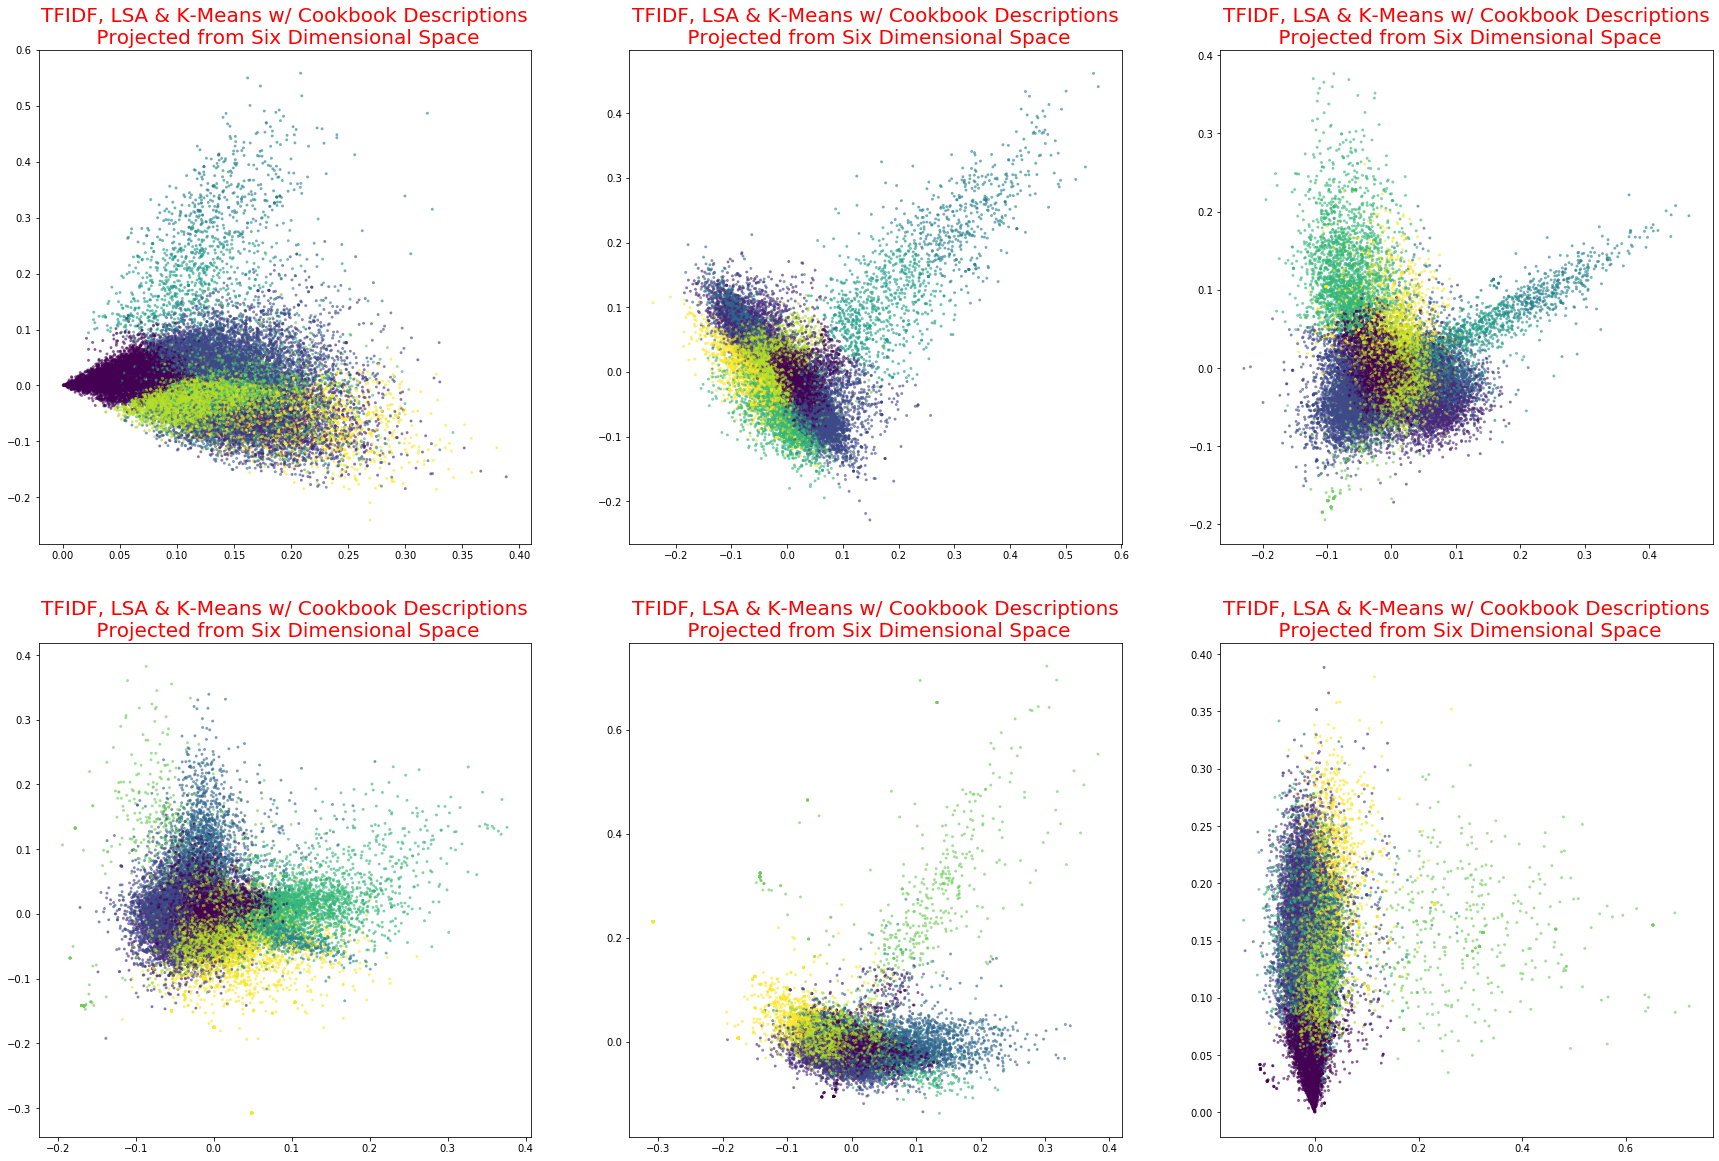

In [109]:
kmeans = KMeans(n_clusters=10, random_state=30).fit(dr_data_desc)
kmeans_tfidf_lsa6 = kmeans.labels_

plot_all_dimensions(dr_data_desc, kmeans_tfidf_lsa6, "TFIDF, LSA & K-Means w/ Cookbook Descriptions\n Projected from Six Dimensional Space")

In [111]:
from sklearn import manifold
tsne_model = manifold.TSNE(n_components=2, init='pca', random_state=0)
tsne_desc_tfidf_lsa6 = tsne_model.fit_transform(dr_data_desc)

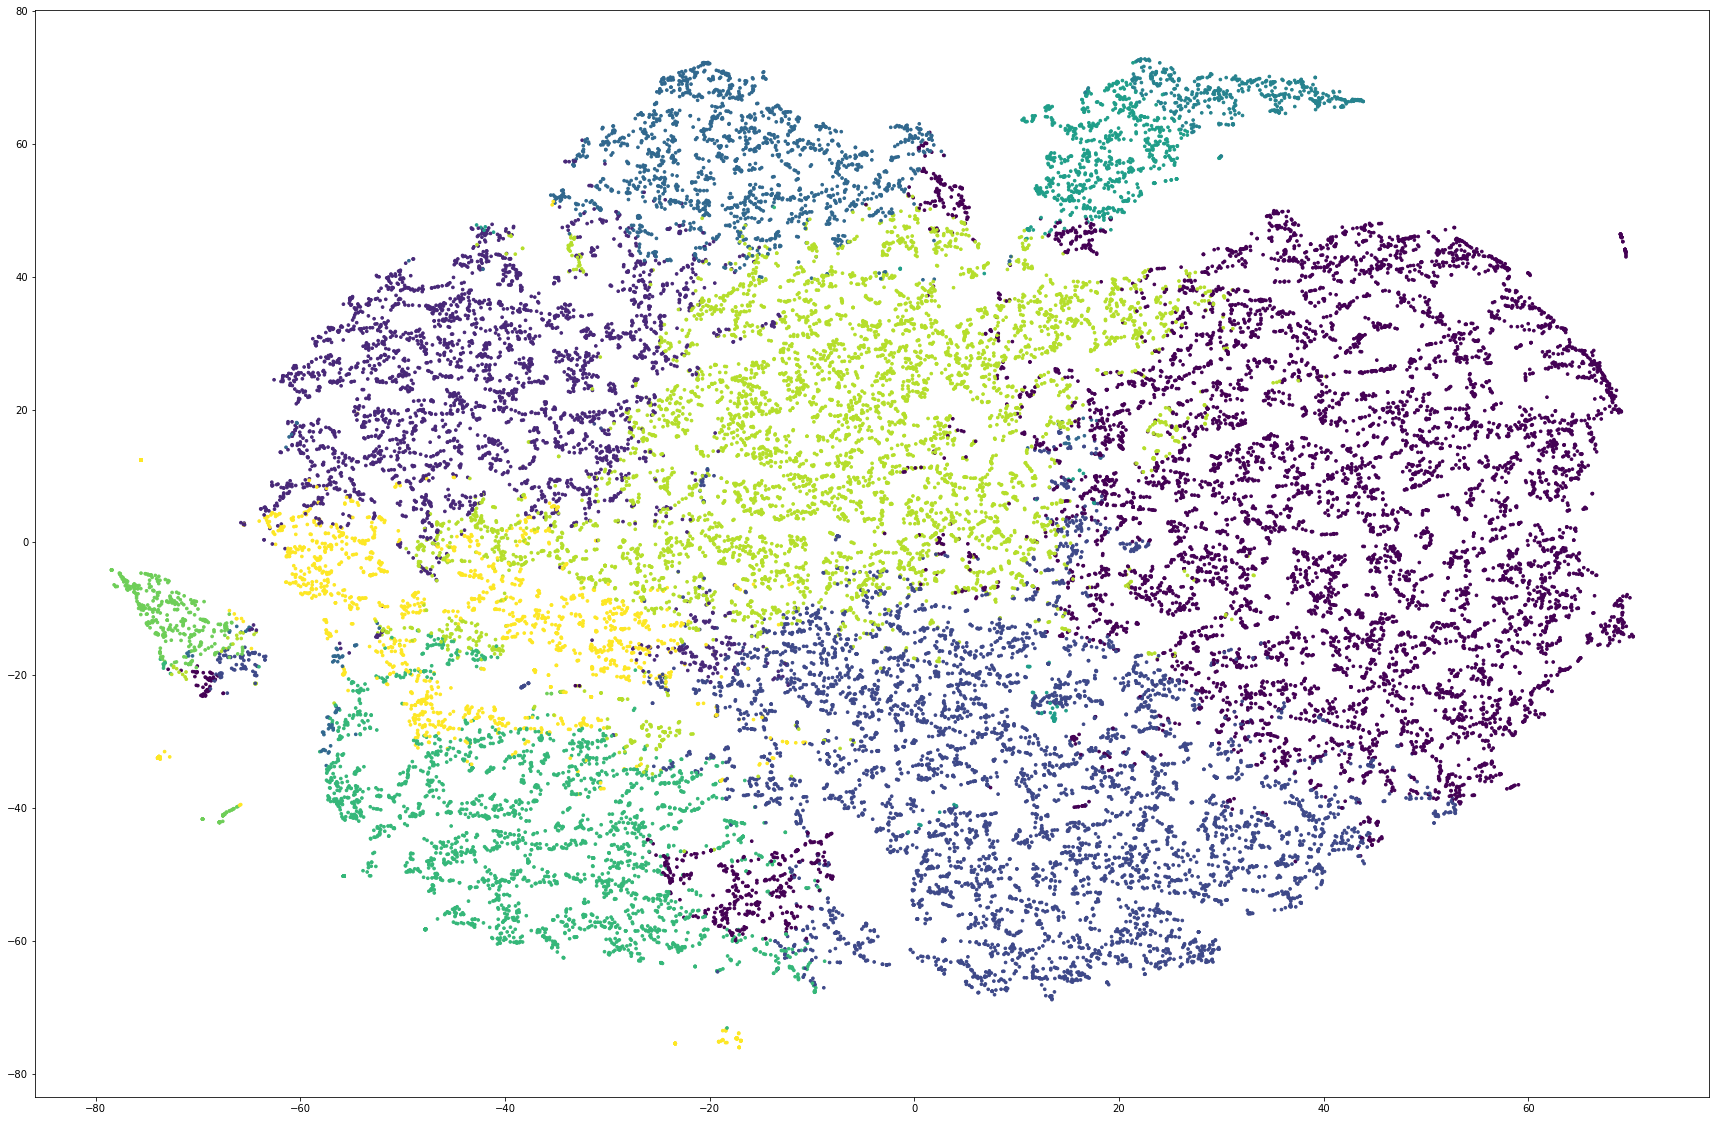

In [119]:
plt.scatter(tsne_desc_tfidf_lsa6[:,0], tsne_desc_tfidf_lsa6[:,1],
           s = 7, c=kmeans.labels_)

In [9]:
vect_methods = ["count", "tfidf"]
dim_reduc = ["PCA", "LSA", "NMF", "LDA"]

ckbk_space = {}

for vect in vect_methods:
    ckbk_space[vect]={}
    for dr in dim_reduc[:-1]:
        print(f"Running NLP on cookbooks using {vect} token vectorization and {dr} dimensionality reduction...")
        model = nlp_model(vect_method = vect, dim_reduc=dr, n_components = 2)
        model.fit(data['title_clean'])
        ckbk_space[vect][dr] = model.doc_dr_data


Running NLP on cookbooks using count token vectorization and PCA dimensionality reduction...
Running NLP on cookbooks using count token vectorization and LSA dimensionality reduction...
Running NLP on cookbooks using count token vectorization and NMF dimensionality reduction...
Running NLP on cookbooks using tfidf token vectorization and PCA dimensionality reduction...
Running NLP on cookbooks using tfidf token vectorization and LSA dimensionality reduction...
Running NLP on cookbooks using tfidf token vectorization and NMF dimensionality reduction...


In [11]:
ckbk_space

{'count': {'PCA': array([[-0.50154409,  0.35545199],
         [-0.50154529,  0.35545692],
         [-0.50154486,  0.355455  ],
         ...,
         [-0.5010936 ,  0.35209144],
         [-0.50127404,  0.35535787],
         [-0.50150804,  0.35549498]]),
  'LSA': array([[ 9.48290373e-05, -7.69543005e-04],
         [ 9.48442543e-05, -7.69572897e-04],
         [ 9.48449095e-05, -7.69713490e-04],
         ...,
         [ 4.46856386e-04, -3.72398190e-03],
         [ 2.30703895e-04, -3.13452857e-04],
         [ 4.78047852e-05, -3.86191336e-04]]),
  'NMF': array([[0.00000000e+00, 1.22307363e-05],
         [0.00000000e+00, 1.22313120e-05],
         [0.00000000e+00, 1.22331046e-05],
         ...,
         [0.00000000e+00, 5.89030025e-05],
         [3.35521814e-07, 6.54432896e-06],
         [0.00000000e+00, 6.14086040e-06]])},
 'tfidf': {'PCA': array([[ 0.0651107 , -0.03823194],
         [ 0.06890119, -0.03903481],
         [ 0.07961974, -0.04153445],
         ...,
         [-0.01351713, -0.0153

In [12]:
dump(ckbk_space, "../model/6models-noUnsup_07Nov19.joblib")

['../model/6models-noUnsup_07Nov19.joblib']

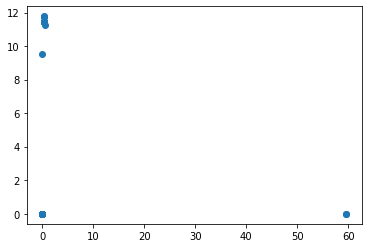

In [13]:
plt.scatter(ckbk_space['count']["NMF"][:,0], ckbk_space['count']["NMF"][:,1])

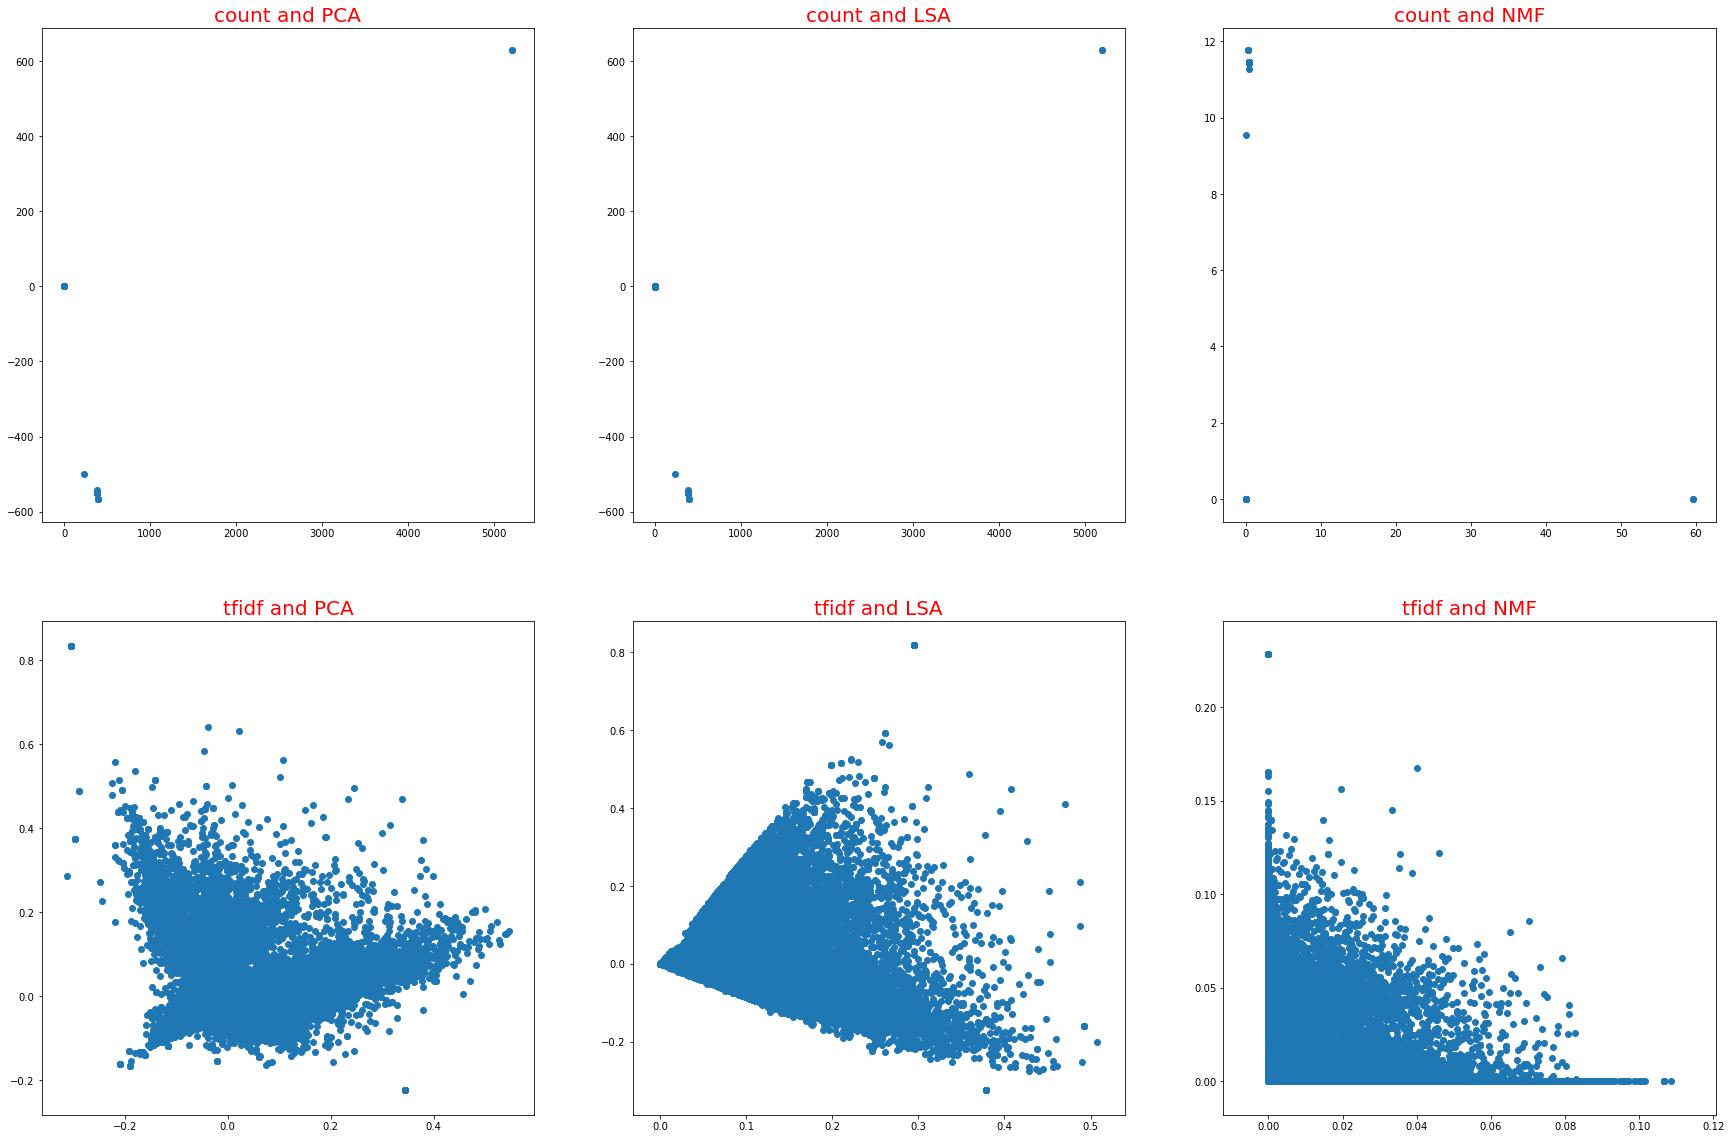

In [19]:
count =1
plt.rcParams['figure.figsize'] = [30, 20]
for vect in vect_methods:
    for dr in dim_reduc[:-1]:
        plt.subplot(2,3, count)
        plt.scatter(ckbk_space[vect][dr][:,0], ckbk_space[vect][dr][:,1])
        plt.title(f"{vect} and {dr}", fontsize=20, color='red')
        count += 1
plt.show()

In [57]:
# --- Check title that have too far on x-axis for count vectorization
# Using NMF
data_count_nmf = ckbks[['asin', 'title', 'title_clean', 'title_count']].copy()
data_count_nmf['nmf_x1'] = ckbk_space['count']['NMF'][:,0]
data_count_nmf['nmf_x2'] = ckbk_space['count']['NMF'][:,1]
data_count_nmf[np.logical_and(data_count_nmf['nmf_x1']<10, data_count_nmf['nmf_x2']>8) ]

,asin,title,title_clean,title_count,nmf_x1,nmf_x2
44158,B0013MTUM8,var aPageStart = (new Date()).getTime();\nvar ...,var aPageStart = (new Date()).getTime(); var u...,65079,0.347572,11.764846
44165,B0015CUKBG,var aPageStart = (new Date()).getTime();\nvar ...,var aPageStart = (new Date()).getTime(); var u...,62905,0.413062,11.457249
44166,B0015KEZFK,var aPageStart = (new Date()).getTime();\nvar ...,var aPageStart = (new Date()).getTime(); var u...,62907,0.421432,11.419952
44172,B00164GDVO,var aPageStart = (new Date()).getTime();\nvar ...,var aPageStart = (new Date()).getTime(); var u...,62925,0.413175,11.457301
44177,B00177W7AG,var aPageStart = (new Date()).getTime();\nvar ...,var aPageStart = (new Date()).getTime(); var u...,65025,0.348327,11.762306
44206,B001DAFS62,var aPageStart = (new Date()).getTime();\nvar ...,var aPageStart = (new Date()).getTime(); var u...,65041,0.348331,11.762301
44207,B001DBQ3AG,var aPageStart = (new Date()).getTime();\nvar ...,var aPageStart = (new Date()).getTime(); var u...,62905,0.421551,11.419945
44213,B001EUS64C,var aPageStart = (new Date()).getTime();\nvar ...,var aPageStart = (new Date()).getTime(); var u...,62956,0.413162,11.457320
44214,B001F7ATTE,var aPageStart = (new Date()).getTime();\nvar ...,var aPageStart = (new Date()).getTime(); var u...,62962,0.413180,11.457256
44221,B001GTME76,var aPageStart = (new Date()).getTime();\nvar ...,var aPageStart = (new Date()).getTime(); var u...,62864,0.421609,11.420110


In [73]:
html = data_count_nmf.iloc[44206]['title']

import urllib
from bs4 import BeautifulSoup

#url = "http://www.cnn.com"
#html = urllib.urlopen(url).read()
soup = BeautifulSoup(html)

# kill all script and style elements
for script in soup(["script", "style"]):
    script.decompose()    # rip it out

# get text
text = soup.get_text()

# break into lines and remove leading and trailing space on each
lines = (line.strip() for line in text.splitlines())
# break multi-headlines into a line each
chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
# drop blank lines
text = '\n'.join(chunk for chunk in chunks if chunk)

print(text)

var aPageStart = (new Date()).getTime();
var ue_t0=ue_t0||+new Date();
window.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;
if (window.ue_ihb === 1) {
var ue_csm = window,
ue_hob = +new Date();
(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new Date};e.d=function(b){return f()-(b?0:d.ue_t0)};e.stub=function(b,a){if(!b[a]){var c=[];b[a]=function(){c.push([c.slice.call(arguments),e.d(),d.ue_id])};b[a].replay=function(b){for(var a;a=c.shift();)b(a[0],a[1],a[2])};b[a].isStub=1}};e.exec=function(b,a){return function(){if(1==window.ueinit)try{return b.apply(this,arguments)}catch(c){ueLogError(c,{attribution:a||"undefined",logLevel:"WARN"})}}}})(ue_csm);
var ue_err_chan = 'jserr-rw';
(function(d,e){function h(f,b){if(!(a.ec>a.mxe)&&f){a.ter.push(f);b=b||{};var c=f.logLevel||b.logLevel;c&&c!==k&&c!==m&&c!==n&&c!==p||a.ec++;c&&c!=k||a.ecf++;b.pageURL=""+(e.location?e.location.href:"");b.logLevel=c;b.attribution=f.attribution||b.attribution;a.erl.push({ex:f,info:b})}}functi

In [85]:
model = nlp_model(vect_method = 'count', dim_reduc="NMF", n_components = 2)
model.fit(data['title_clean'])
count_nmf2 = model.doc_dr_data

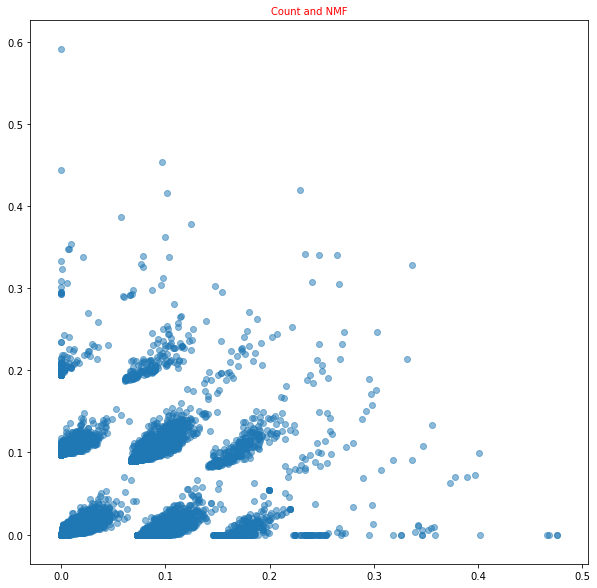

In [94]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(count_nmf2[:,0], count_nmf2[:,1], alpha = 0.5)
plt.title(f"Count and NMF", fontsize=10, color='red')
plt.show()

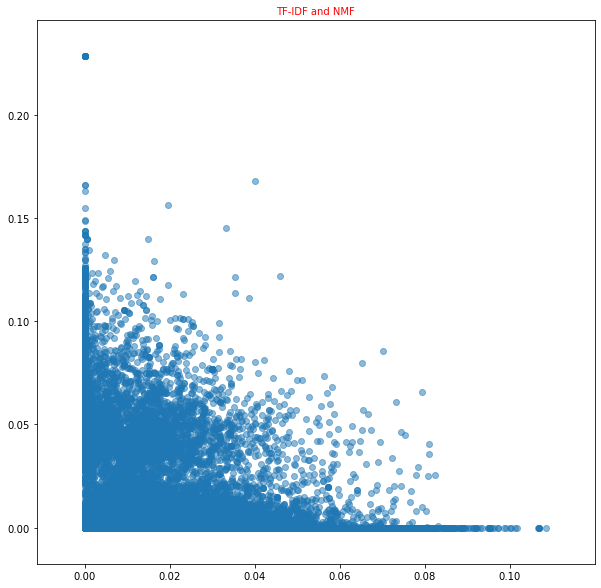

In [95]:
model = nlp_model(vect_method = 'tfidf', dim_reduc="NMF", n_components = 2)
model.fit(data['title_clean'])
count_nmf3 = model.doc_dr_data
plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(count_nmf3[:,0], count_nmf3[:,1], alpha = 0.5)
plt.title(f"TF-IDF and NMF", fontsize=10, color='red')
plt.show()

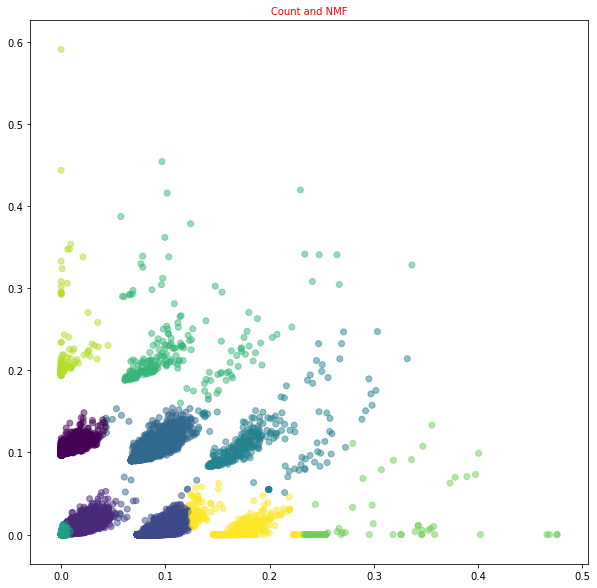

In [103]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 10))

kmeans = KMeans(n_clusters=10, random_state=30).fit(count_nmf2)
count_nmf2_kmeans = kmeans.labels_
plt.rcParams['figure.figsize'] = [10, 10]

plt.scatter(count_nmf2[:,0], count_nmf2[:,1], alpha = 0.5, c=count_nmf2_kmeans)# cmap=colors)
plt.title(f"Count and NMF", fontsize=10, color='red')
plt.show()

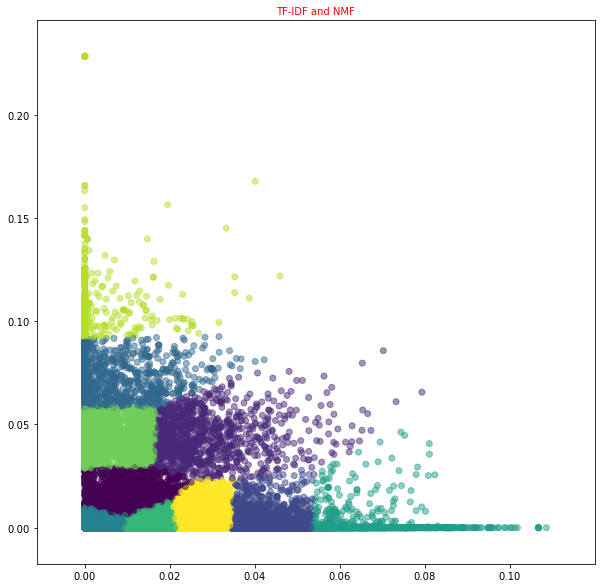

In [104]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 10))

kmeans = KMeans(n_clusters=10, random_state=30).fit(count_nmf3)
count_nmf3_kmeans = kmeans.labels_
plt.rcParams['figure.figsize'] = [10, 10]

plt.scatter(count_nmf3[:,0], count_nmf3[:,1], alpha = 0.5, c=count_nmf3_kmeans)# cmap=colors)
plt.title(f"TF-IDF and NMF", fontsize=10, color='red')
plt.show()

In [108]:
data_nmfs = data.copy()
data_nmfs['count_nmf'] = count_nmf2_kmeans
data_nmfs['tfidf_nmf'] = count_nmf3_kmeans

In [122]:
print(data_nmfs['count_nmf'].value_counts())
data_nmfs[data_nmfs['count_nmf']==5].tail(20)

5    18385
2     9373
1     7611
0     5148
3     2772
9      706
4      301
6      238
8      197
7       72
Name: count_nmf, dtype: int64


,asin,title,title_clean,desc,title_count,count_nmf,tfidf_nmf
44798,B0145X6SQC,Bacon Love! 2016 Day-to-Day Calendar,bacon love day to day calendar,['Andrews McMeel Publishing is a leading publi...,6,5,6
44799,B0147L6T2U,Designer Handbag Cakes,designer handbag cakes,"['', 'Have your handbag and eat it too! Let ce...",3,5,4
44800,B0147L5U66,The Wilton Method: Decorating with Fondant,the wilton method decorating with fondant,"['', 'Get rolling and learn to cover round, sq...",6,5,4
44801,B0147L5T2Q,Classic Croissants at Home,classic croissants at home,"['', 'A flaky croissant fresh from the oven! P...",4,5,0
44802,B0147L8GLC,Handmade Sourdough: From Starter to Baked Loaf,handmade sourdough from starter to baked loaf,"['', 'Make artisanal sourdough your household ...",7,5,4
44803,B0147L882O,A Modern Take on the Mother Sauces,a modern take on the mother sauces,"['', 'Master the mother sauces at the heart of...",7,5,4
44805,B014I7GNT2,Just Time For A Quickie! (Copyright 2015) by J...,just time for a quickie copyright by juli...,['The Kidd Sisters have turned up the heat in ...,14,5,4
44806,B016107TYM,The Betty Crocker Recipe Card Library,the betty crocker recipe card library,['A delightful set of recipe cards.'],6,5,4
44808,B017BZQELK,"HOME COOKIN' IS A FAMILY AFFAIR, Compiled by t...",home cookin is a family affair compiled by t...,"[""Here for your delectation is the SPECTACULAR...",17,5,4
44813,B019DKJW42,"Raising the Coffee Bar, Sofia Coffee Recipe Bo...",raising the coffee bar sofia coffee recipe bo...,"[""Bringing the Coffeehouse Home100 Irresistibl...",9,5,4


In [120]:
print(data_nmfs['tfidf_nmf'].value_counts())
data_nmfs[data_nmfs['tfidf_nmf']==6].head(20)

4    14323
6     9340
9     6785
0     4384
2     3510
7     2382
3     1444
5     1206
1     1047
8      382
Name: tfidf_nmf, dtype: int64


,asin,title,title_clean,desc,title_count,count_nmf,tfidf_nmf
6,0002251337,Balsamic Vinegar Cookbook,balsamic vinegar cookbook,"[""An estimated 1.75 million liters of commerci...",3,0,6
8,0002250713,The Artist's Table: A Cookbook by Master Chefs...,the artist s table a cookbook by master chefs...,"[""How would you like to dine in Van Gogh's oli...",18,0,6
13,0002251280,Dinner Parties (Easy Entertaining Series),dinner parties easy entertaining series,['Dinner Parties presents 10 diverse menus for...,5,1,6
16,0002550857,The Best of Italy,the best of italy,"[""This wonderful series is the easiest way to ...",4,5,6
17,0002551489,The Best of Mexico,the best of mexico,"[""This wonderful series is the easiest way to ...",4,5,6
20,0002553457,Pears: A Country Garden Cookbook,pears a country garden cookbook,"[""Beautifully designed and exquisitely photogr...",5,0,6
23,0002553465,Squash: A Country Garden Cookbook,squash a country garden cookbook,['More than 40 sumptuous squash recipes -- suc...,5,0,6
24,0002551497,The Best of China,the best of china,['Great pics of food and excellent recipes. Sp...,4,5,6
29,0002553724,Australia the Beautiful Cookbook,australia the beautiful cookbook,['Each title in this award-winning series offe...,4,0,6
30,000255464X,"The Best of Beautiful Cookbooks: France, Italy...",the best of beautiful cookbooks france italy...,['Ships from Missouri next business day.'],11,5,6
